In [1]:
%matplotlib inline
from run_dnerf import config_parser, create_nerf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from load_blender import pose_spherical
from run_dnerf import render_path
from run_dnerf_helpers import to8b
from scipy.spatial.transform import Rotation as R
import numpy as np
import cv2 as cv

In [2]:
# set cuda
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get config file
config_file = "configs/ball_cube_2.txt"
parser = config_parser()
args = parser.parse_args(f'--config {config_file}')

# set render params
hwf = [400, 400, 555.555]
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 2., 'far' : 6.})

camera_intrinsic = np.eye(3)
camera_intrinsic[0,0] = hwf[2]
camera_intrinsic[1,1] = hwf[2]
camera_intrinsic[0,2] = hwf[0] / 2
camera_intrinsic[1,2] = hwf[1] / 2

model = render_kwargs_test['network_fn']
network_query_fn = render_kwargs_test['network_query_fn']
displacement_query_fn = render_kwargs_test['displacement_query_fn']
print(model.input_ch)

NeRF type selected: direct_temporal
Found ckpts ['./logs/ball_cube_frame_fix_2/050000.tar', './logs/ball_cube_frame_fix_2/100000.tar', './logs/ball_cube_frame_fix_2/150000.tar', './logs/ball_cube_frame_fix_2/200000.tar', './logs/ball_cube_frame_fix_2/250000.tar', './logs/ball_cube_frame_fix_2/300000.tar', './logs/ball_cube_frame_fix_2/350000.tar', './logs/ball_cube_frame_fix_2/400000.tar', './logs/ball_cube_frame_fix_2/450000.tar', './logs/ball_cube_frame_fix_2/500000.tar', './logs/ball_cube_frame_fix_2/550000.tar', './logs/ball_cube_frame_fix_2/600000.tar', './logs/ball_cube_frame_fix_2/650000.tar', './logs/ball_cube_frame_fix_2/700000.tar', './logs/ball_cube_frame_fix_2/750000.tar', './logs/ball_cube_frame_fix_2/800000.tar', './logs/ball_cube_frame_fix_2/latest.tar']
Reloading from ./logs/ball_cube_frame_fix_2/latest.tar
63


## Generate Frame

In [3]:
def generate_img(time, azimuth, elevation):
    assert 0. <= time <= 1.
    assert -180 <= azimuth <= 180
    assert -180 <= elevation <= 180
    render_poses = torch.unsqueeze(pose_spherical(azimuth, elevation, 4.0), 0).to(device)
    
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, _ = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    return rgbs[0]

100%|██████████| 1/1 [00:57<00:00, 57.58s/it]


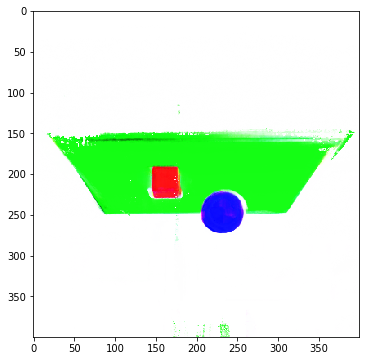

In [4]:
# generate rgb images
times_min = 0.0
times_max = 1.0
times_n = 30
azimuth = 180  # in [-180,180]
elevation = 20  # in [-180,180]
imgs = []
for time in np.linspace(times_min,times_max,times_n):
    img = generate_img(time, azimuth, elevation)
    imgs.append(img)

# display
plt.figure(2, figsize=(20,6))
plt.imshow(img)
plt.show()

In [5]:
for i in range(len(imgs)):
    img = imgs[i]
    cv.imwrite("rgb_{0}.png".format(i), img)

In [6]:
sample_mins = [-4.0, -4.0, -4.0]
sample_maxs = [4.0, 4.0, 4.0]
sample_ns = [10, 10, 10]

x_samples = torch.Tensor(np.linspace(sample_mins[0],sample_maxs[0],sample_ns[0]))
y_samples = torch.Tensor(np.linspace(sample_mins[1],sample_maxs[1],sample_ns[1]))
z_samples = torch.Tensor(np.linspace(sample_mins[2],sample_maxs[2],sample_ns[2]))

grid_x, grid_y, grid_z = torch.meshgrid(x_samples, y_samples, z_samples)

samples_all = torch.zeros((10,10,10,3),dtype=torch.float32)
samples_all[...,0] = grid_x
samples_all[...,1] = grid_y
samples_all[...,2] = grid_z

samples_all = samples_all.flatten(0,2).unsqueeze(0)

In [7]:
times = torch.Tensor(np.linspace(times_min, times_max, times_n))

In [8]:
samples_all.shape

torch.Size([1, 1000, 3])

In [9]:
with torch.no_grad():
    results = []
    for time in times:
        times_in = torch.zeros(1,1, dtype=torch.float32)
        times_in[0,0] = time
        result = displacement_query_fn(samples_all, times_in, model)
        results += [result.unsqueeze(0)]
    results = torch.cat(results,0)
results = results.cpu()

/home/stanlew/anaconda3/envs/dnerf/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


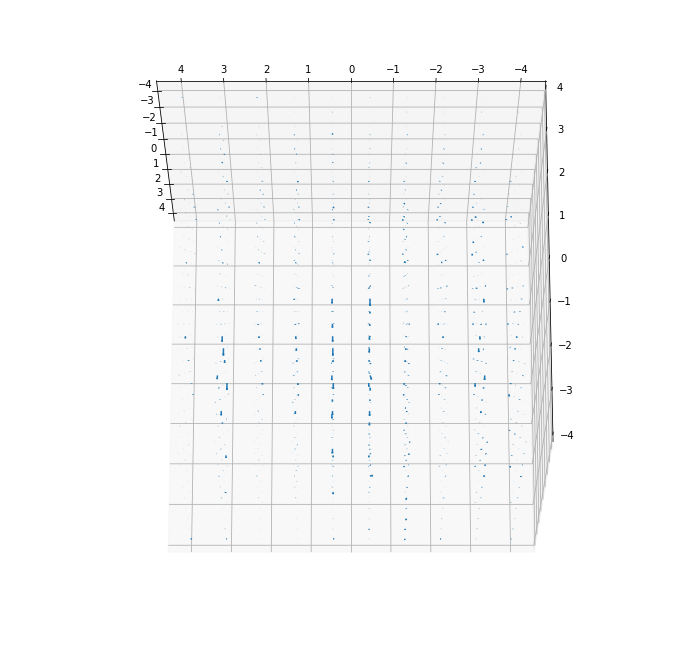

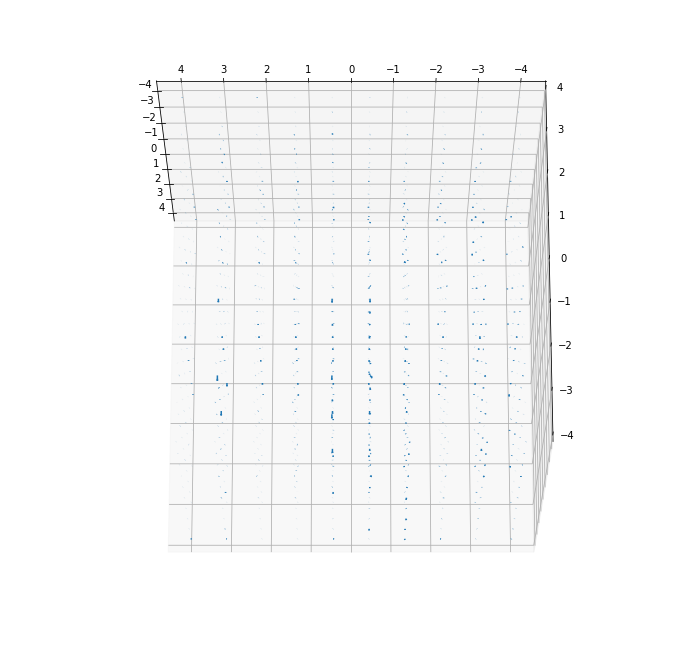

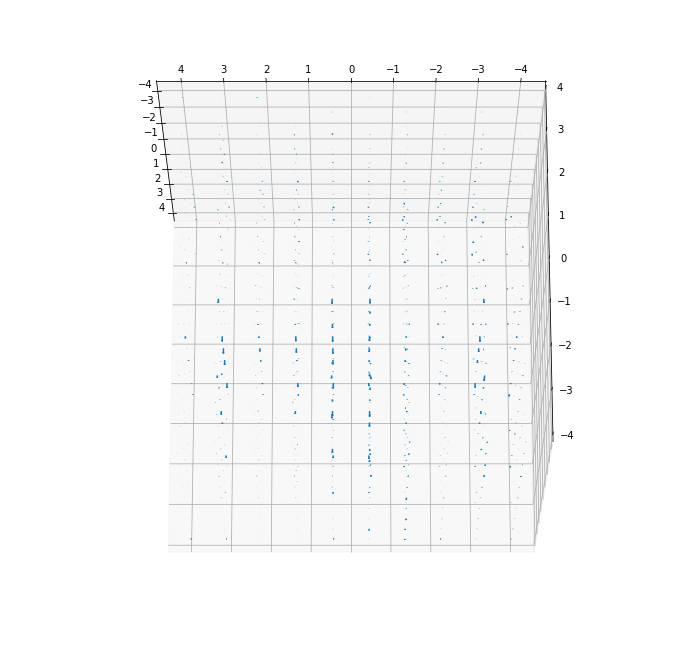

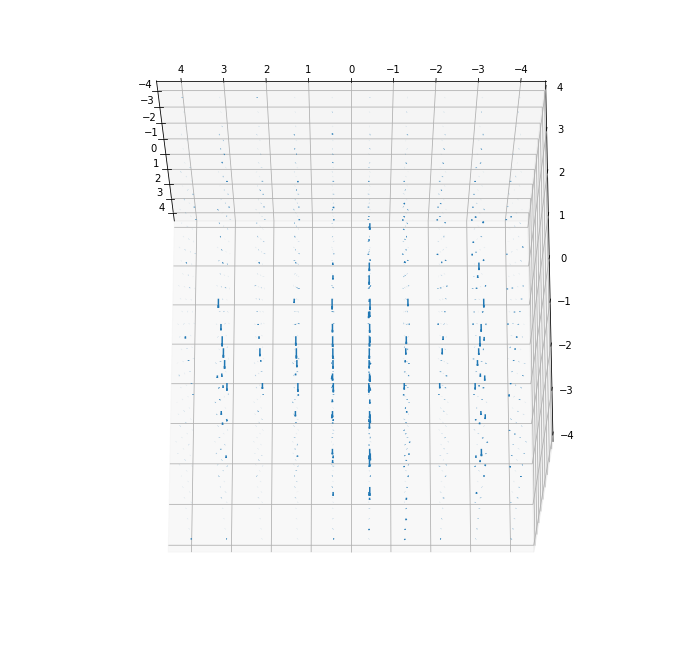

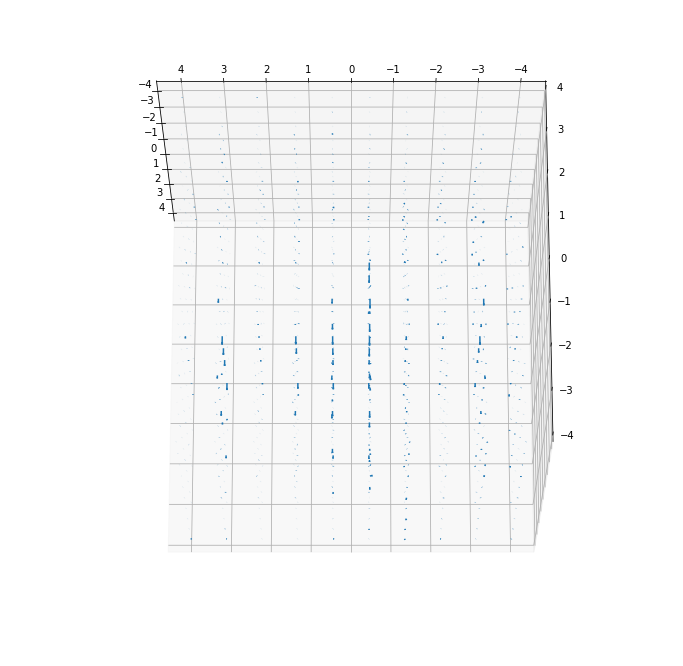

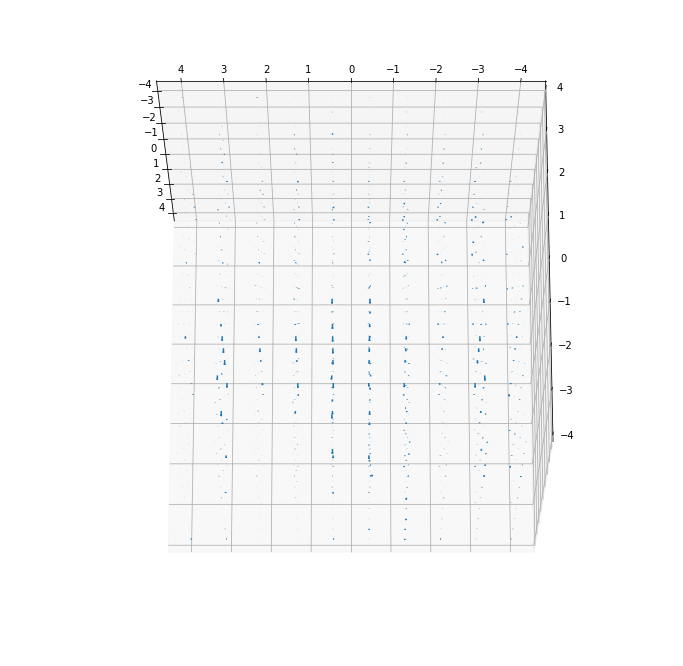

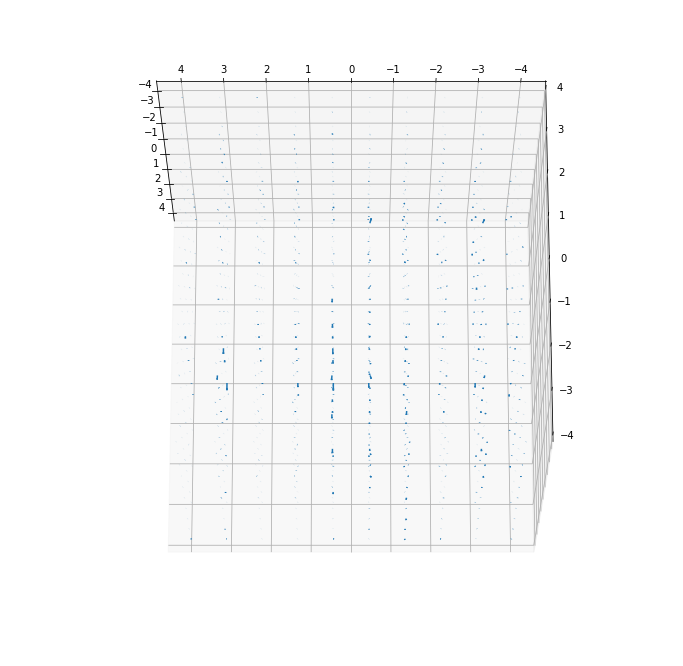

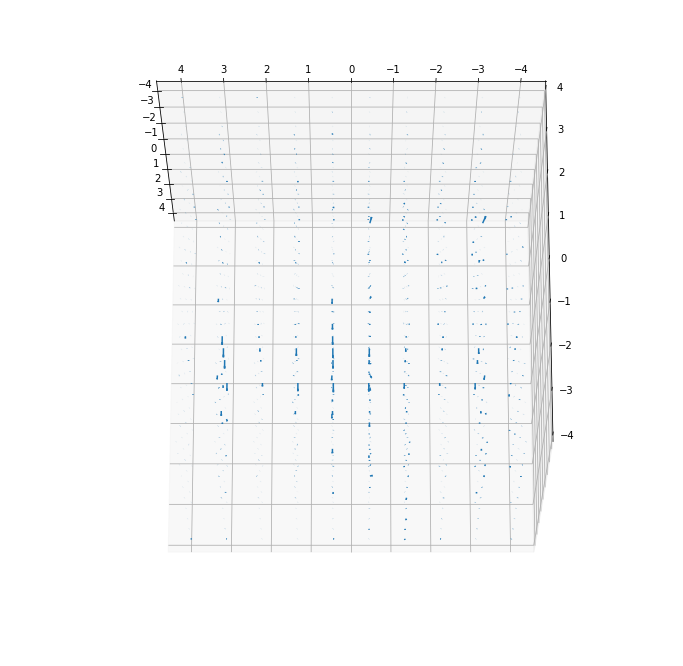

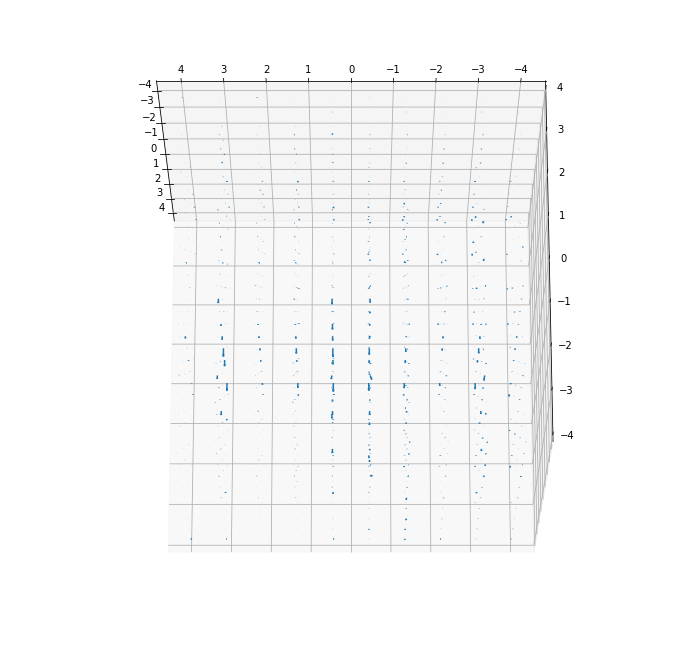

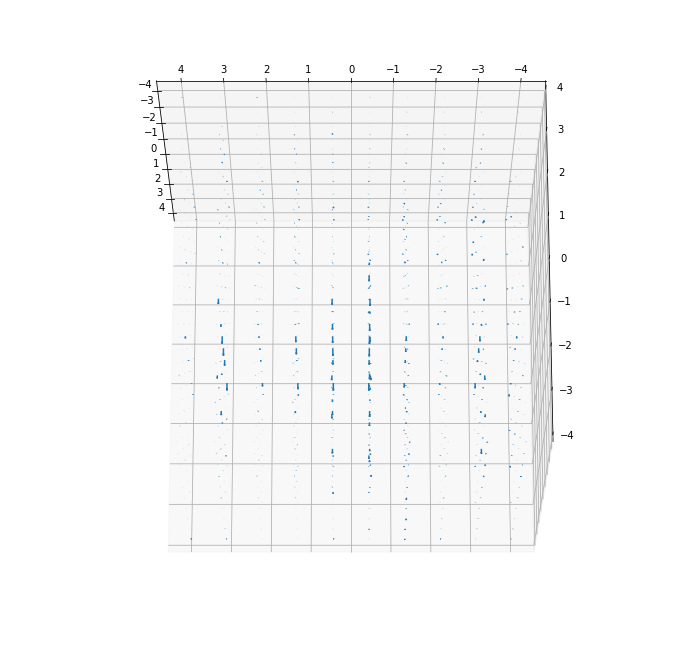

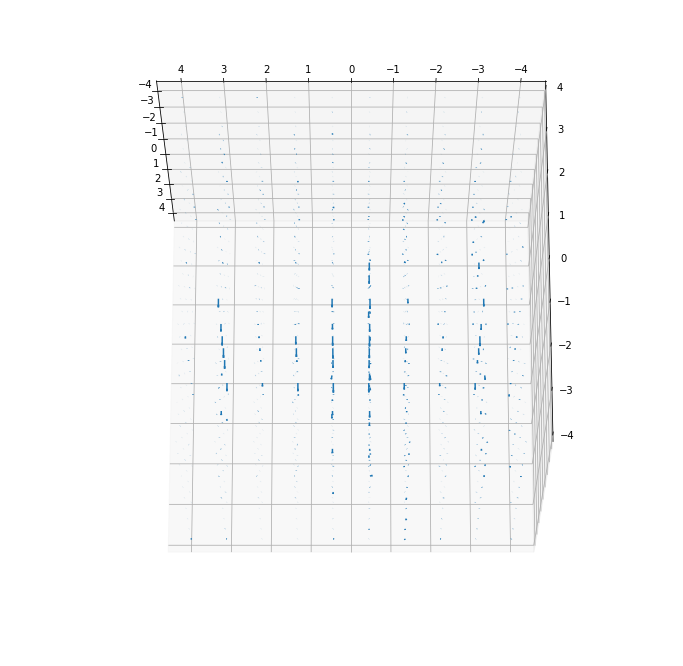

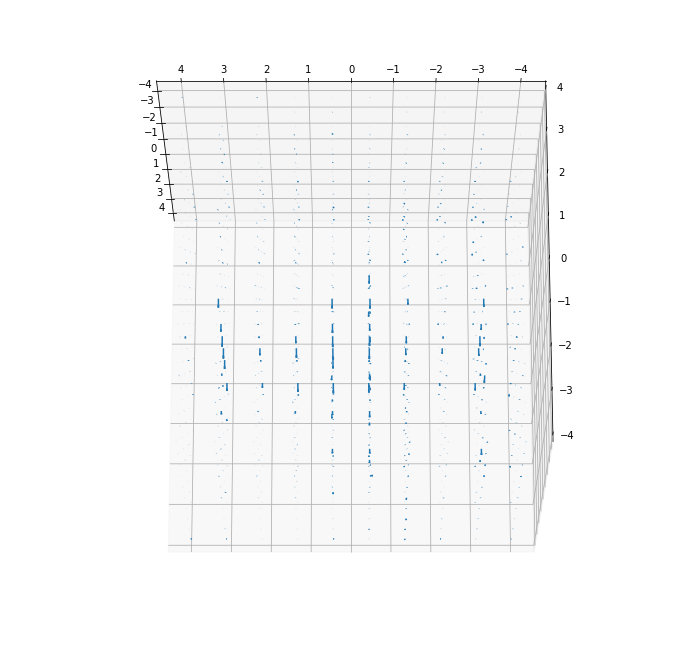

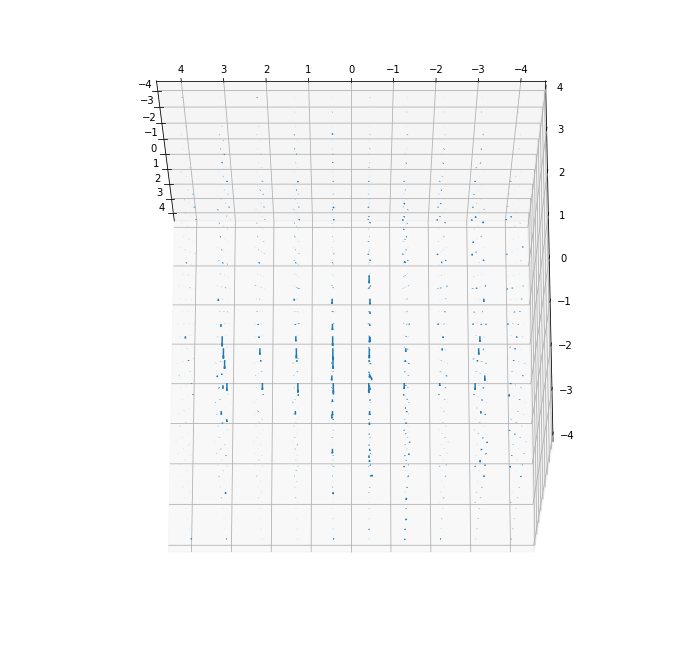

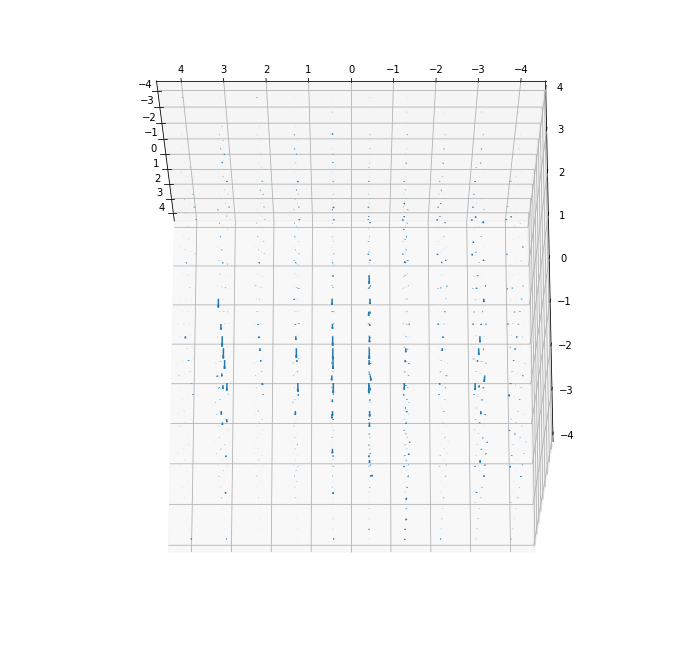

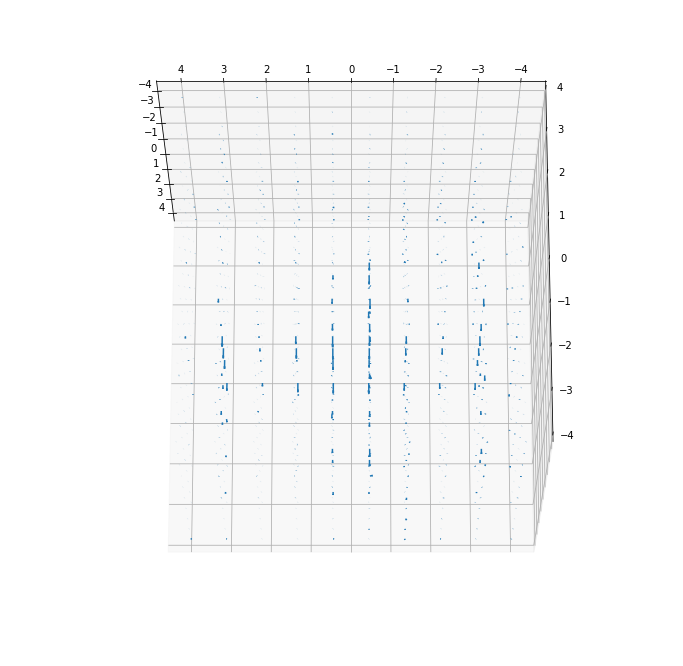

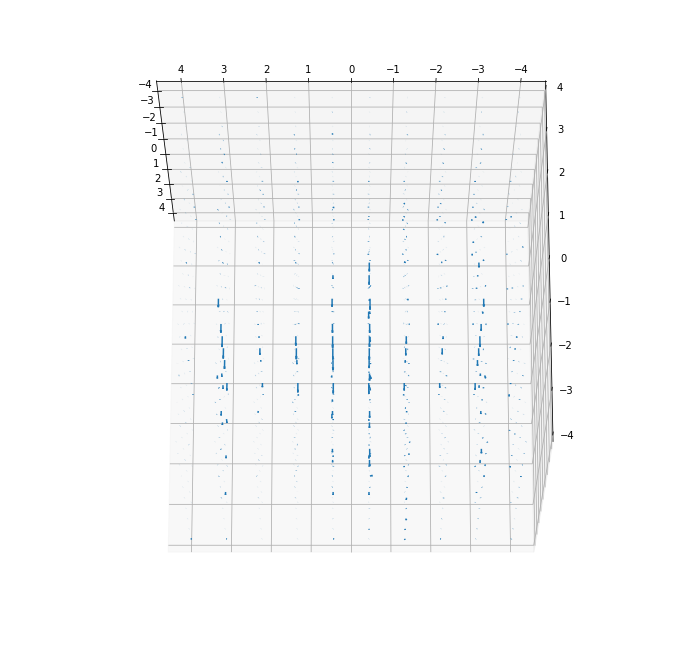

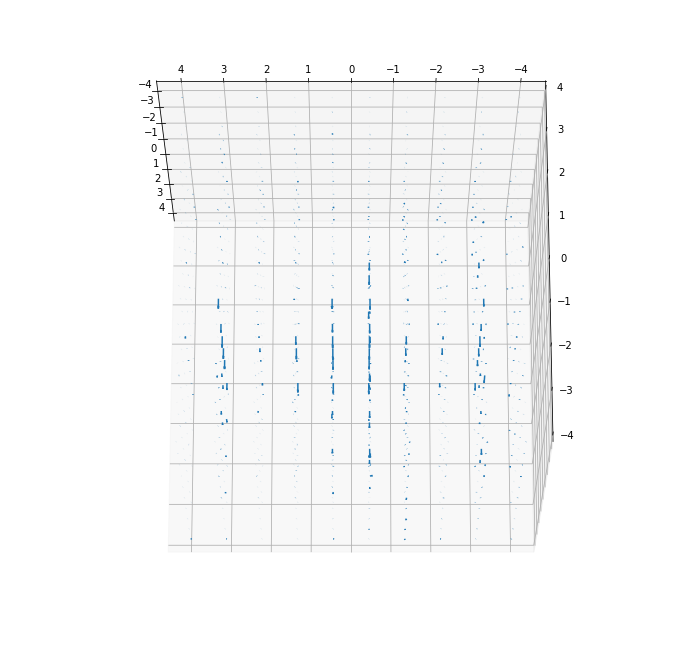

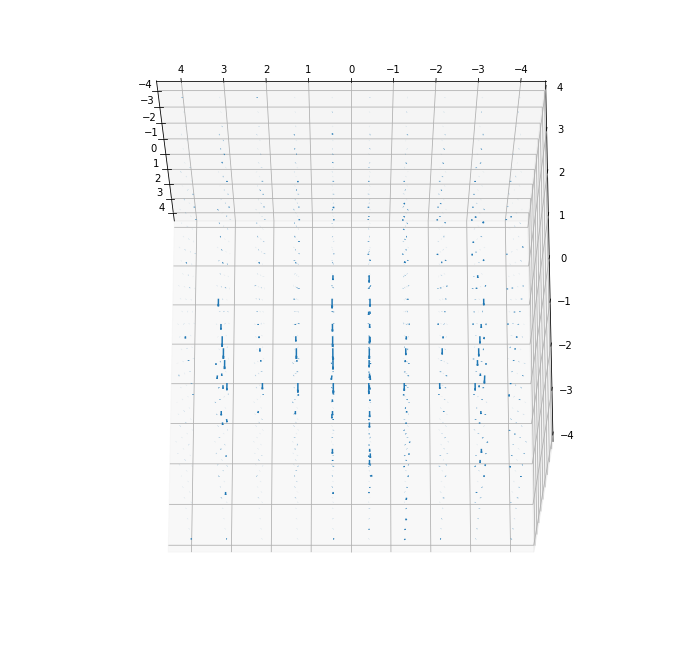

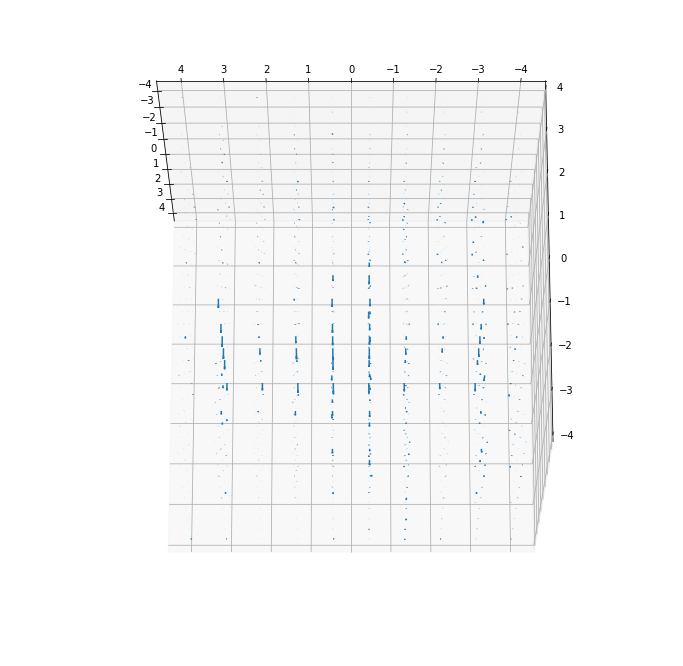

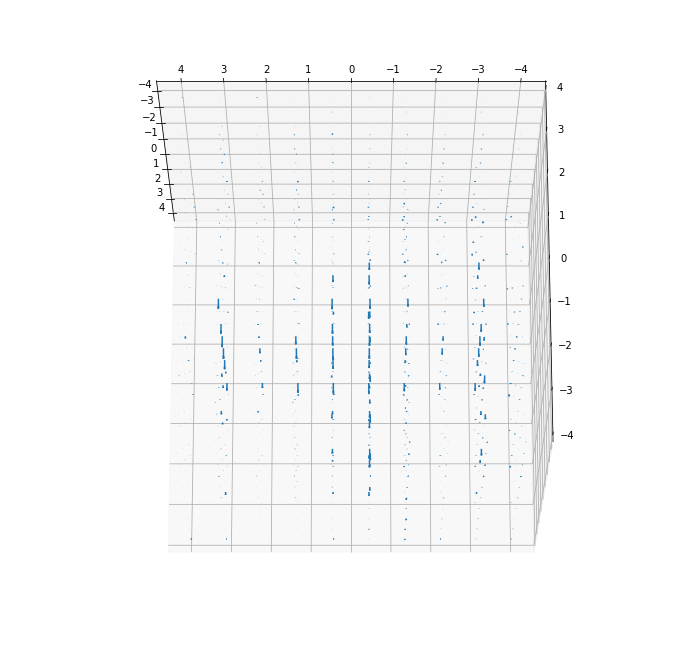

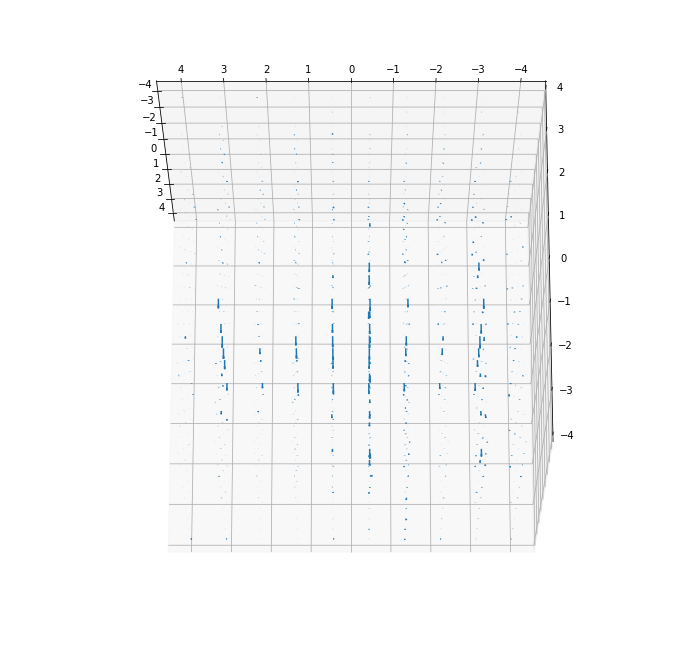

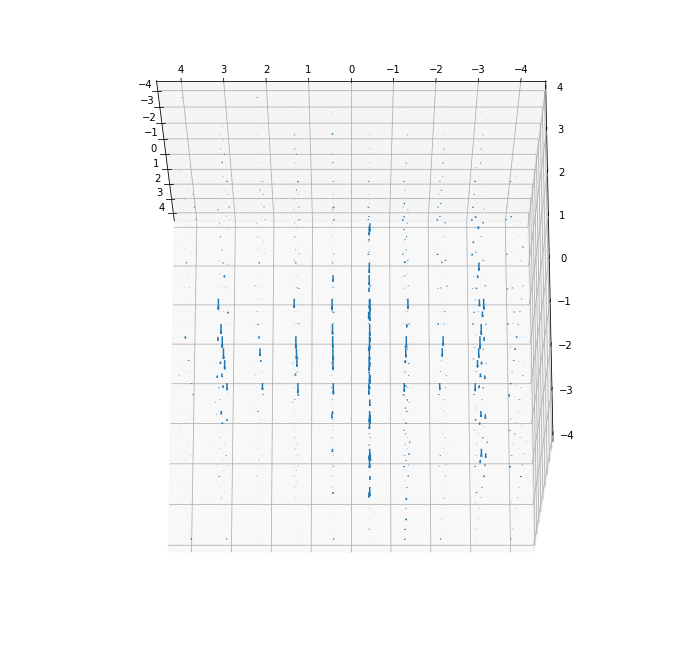

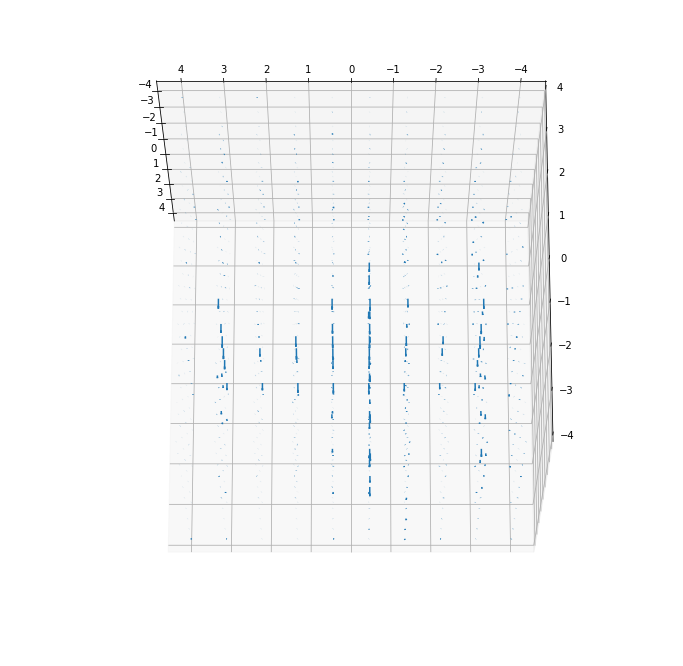

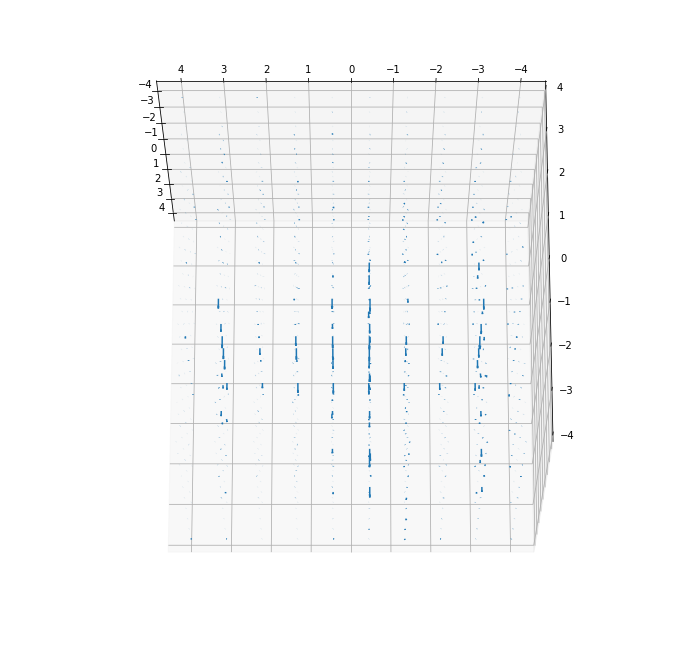

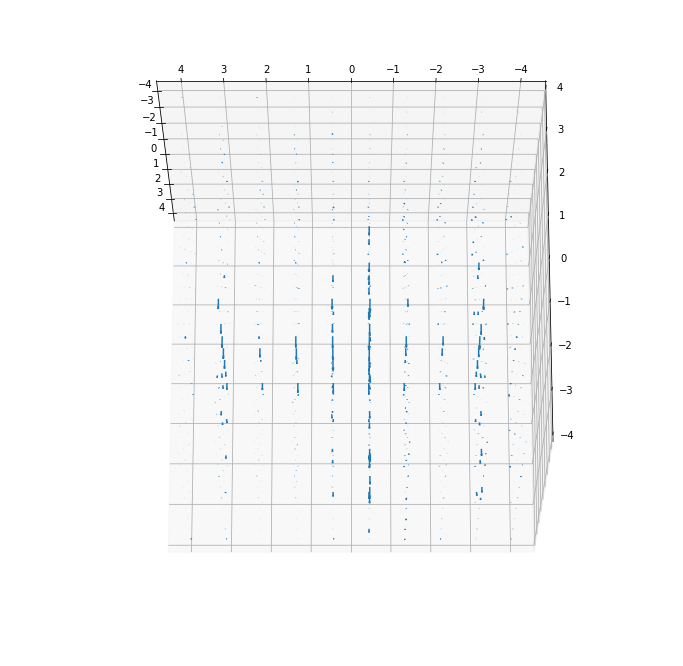

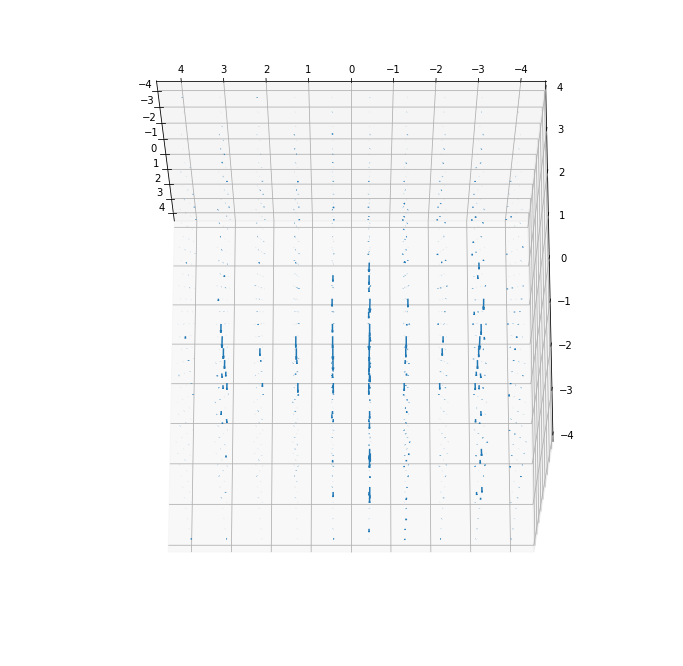

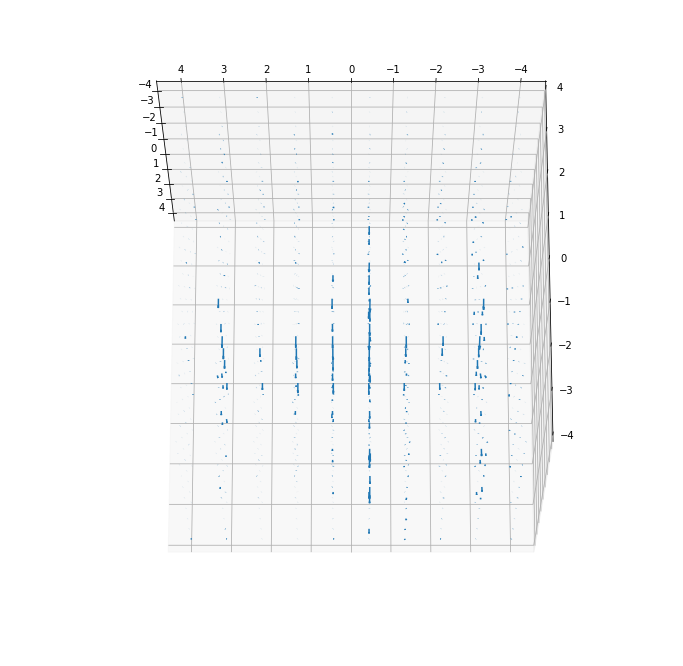

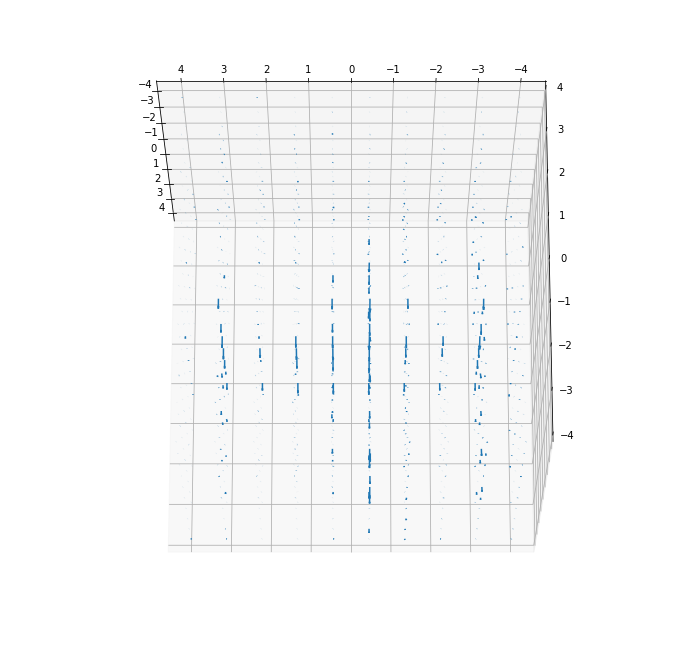

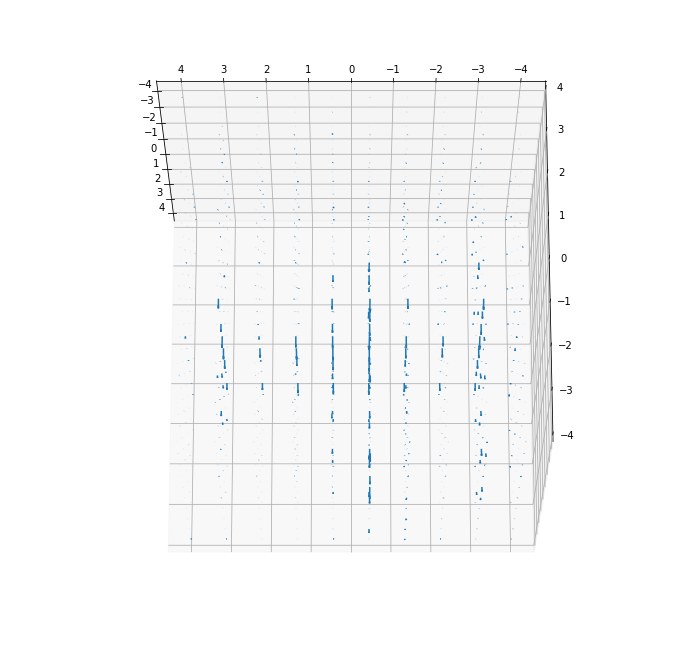

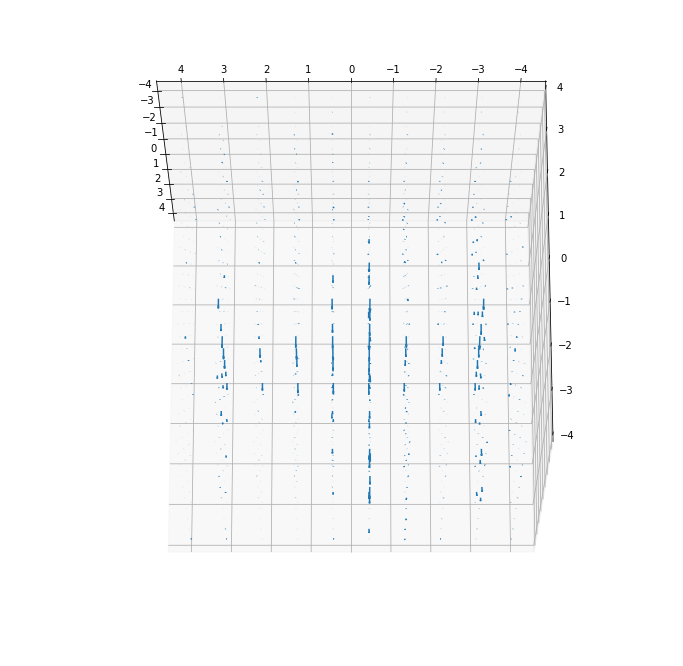

In [10]:
grid_x = grid_x.cpu().flatten()
grid_y = grid_y.cpu().flatten()
grid_z = grid_z.cpu().flatten()

for i in range(times.shape[0]):
    u = results[i,:,0]
    v = results[i,:,1]
    w = results[i,:,2]
    ax = plt.figure(figsize=(12,12)).add_subplot(projection='3d')
    ax.view_init(elev=-1*elevation, azim=azimuth)
    ax.quiver(grid_x, grid_y, grid_z, u, v, w, cmap='jet')
    plt.savefig("quiver_{0}.png".format(i))